In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"

In [2]:
import time
import os
import numpy as np
import gc
from mu2etools import *
from mu2etools import wideband
import hist
from hist import Hist

hep.style.use('ATLAS')

In [3]:
runs = [2070]
processor = wideband.DataProcessor(treename='run', runlist=runs, userunlist=True, remove=False,fixtimes=True)
filelist = processor.getFilelist(DATASET, root_schema=True)
filelist = ["{}{}".format(i, ":run") for i in filelist]

In [9]:
varlist = ['PEs','time']

h = Hist(hist.axis.Regular(bins=200, start=-100, stop=100, name="time difference"))

for idx, filename in enumerate(filelist):
    print(filename)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="100MB", 
                               filter_name=varlist, 
                               report=False, library='ak'):
            ar['PEs'] = ak.where(ar['PEs'] >= 5, ar['PEs'], 0)
            for chan in range(64):
                ar_chan = ar[(ar['PEs'][:,0,chan] > 0)]
                ar_chan['timediff'] = ar_chan['time'][:,0,chan] - ar_chan['time'][:,4,chan]
                h.fill(ar_chan['timediff'])

root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/7c/4f/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_001.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/1e/da/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_002.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/bc/ec/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_003.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/6d/35/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_004.root:run


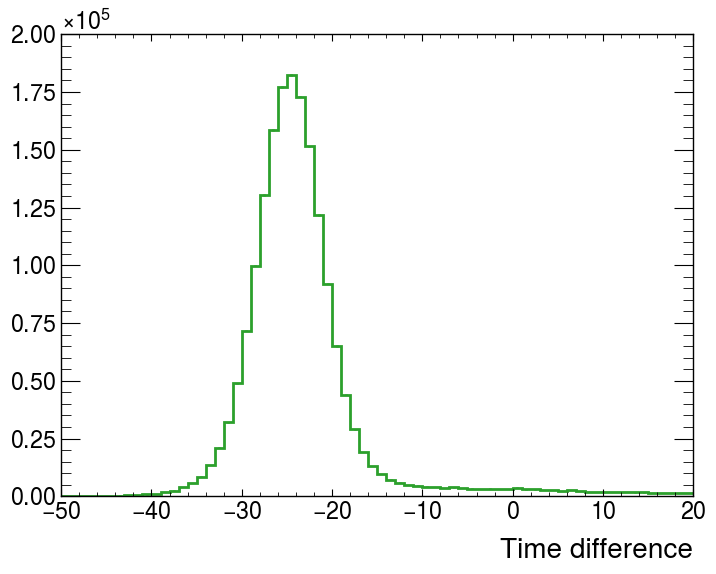

In [10]:
fig, ax = plt.subplots()
h.plot1d(color='#2ca02c', linewidth=2.0)
ax.set_xlabel('Time difference')
#ax.set_yscale('log')
ax.set_xlim(-50, 20)
plt.show()

In [5]:
varlist = ['PEs','time','fitStatus']

hc = Hist(hist.axis.Regular(bins=200, start=0, stop=1, name="speed of light"))

for idx, filename in enumerate(filelist):
    print(filename)
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="10MB", 
                               filter_name=varlist, 
                               report=False, library='ak'):
            ar['PEs'] = ak.where(ar['PEs'] >= 20, ar['PEs'], 0) # much more strict cut
            for chan in range(64):
                for FEB in range(4):
                    ar_chan = ar[(ar['PEs'][:,FEB,chan] > 0) & (ar['PEs'][:,FEB+4,chan] > 0) & (ar['fitStatus'][:,FEB,chan] == 1) & (ar['fitStatus'][:,FEB+4,chan] == 1)]
                    ar_chan['c'] = 4/((ar_chan['time'][:,FEB+4,chan] - ar_chan['time'][:,FEB,chan])*0.299792458)
                    hc.fill(ar_chan['c'])

root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/7c/4f/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_001.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/1e/da/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_002.root:run
root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/bc/ec/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_003.root:run


/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/6d/35/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.002070_004.root:run


In [13]:
mean = 0
std = 0
mpv = 0
bins = np.linspace(0.005, 0.995, 200)
for i, val in enumerate(hc.values()):
    mean += bins[i]*val
    if val == max(hc.values()):
        mpv = bins[i]
mean = mean/hc.sum()

for i, val in enumerate(hc.values()):
    std += val*(bins[i] - mean)**2
std = np.sqrt(std/hc.sum())

print("Mean:", mean)
print("Standard deviation:", std)
print("MPV:", mpv)

Mean: 0.5434395956307622
Standard deviation: 0.08945056444575497
MPV: 0.5024874371859296


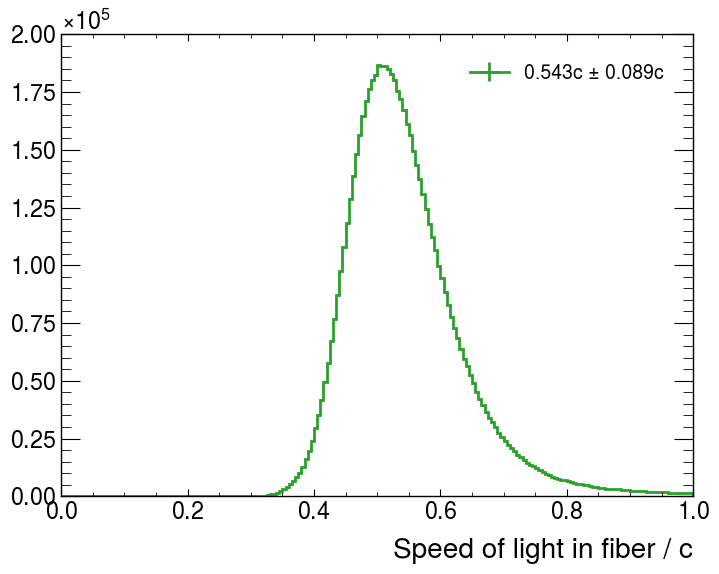

In [14]:
fig, ax = plt.subplots()
hc.plot1d(color='#2ca02c', linewidth=2.0, label='{0}c ± {1}c'.format(round(mean,3), round(std,3)))
#ax.plot(np.linspace(0,1,200), 186532*np.exp(-0.5*((np.linspace(0,1,200)-mean)/std)**2), linewidth=2.0, color='#ff7f0e')
ax.set_xlabel('Speed of light in fiber / c')
ax.set_xlim(0, 1)
#ax.set_yscale('log')
ax.legend()
plt.show()